In [12]:
import numpy as np
from matplotlib import pyplot as plt
from nustattools.stats import derate_covariance

In [13]:
# Create data sets for comaprison
from ipynb.fs.defs.datasets import N_DIM, N_POINTS, default_sets

BLOCKS = [5, 5]

N_DIM = np.sum(BLOCKS)

datasets = default_sets(N_DIM, type="diagblock", blocks=BLOCKS)

dname = "projected-nightmare-inflated"

2


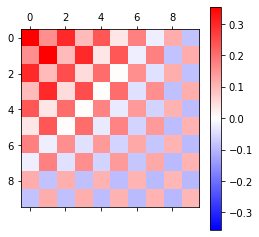

In [14]:
# Projection onto subspace

A = np.array(
    [
        [9, 8, 7, 6, 5, 4, 3, 2, 1, 0],
        [1, -1, 1, -1, 1, -1, 1, -1, 1, -1],
    ],
    dtype=float,
)

K_DIM = len(A)
print(K_DIM)
A = A / np.sqrt(np.sum(A**2, axis=1, keepdims=True))
A = A.T

Q = np.linalg.inv(A.T @ A) @ A.T
P = A @ Q
vm = np.max(np.abs(P))
plt.matshow(P, vmax=vm, vmin=-vm, cmap="bwr")
plt.colorbar()

In [15]:
p_datasets = {}
for name, data in datasets.items():
    p_datasets[name] = (Q @ data.T).T
del datasets

1.799473007193861
(10559596, 2)


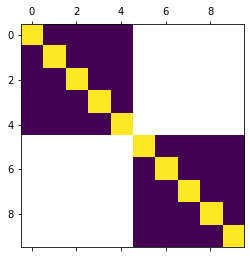

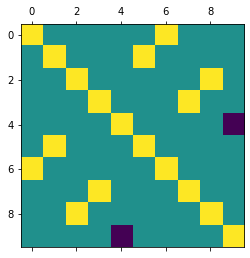

In [16]:
# Get distance function and expected distribution
from ipynb.fs.defs.covfit import fill_max_correlation, inflated, naive
from scipy.stats import chi2

expected = chi2(df=K_DIM)

# Worst case covariance
cov_worst = np.full((N_DIM, N_DIM), np.nan)
# block sizes, only applies to the "block" types of data!
for i, ni in enumerate(BLOCKS):
    bi = int(np.sum(BLOCKS[:i]))
    cov_worst[bi : bi + ni, bi : bi + ni] = np.eye(ni)

plt.matshow(cov_worst)

details = {}
alpha = derate_covariance(cov_worst, jacobian=A, accuracy=0.001, return_dict=details)
print(alpha)
plt.matshow(details["nightmare_cov"])
print(details["throws"].shape)
p_datasets["Nightmare"] = details["throws"]

dist = lambda x: inflated(x, alpha=alpha, cov=Q @ Q.T)

In [17]:
# Compute distances
distances = {}
for name, data in p_datasets.items():
    distances[name] = dist(data)

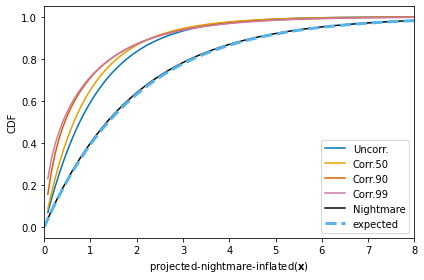

In [18]:
# Compare cumulative distributions
fig, ax = plt.subplots()
x = np.linspace(0, expected.mean() + expected.std() * 3, 100)
for name in distances:
    tot = len(distances[name])
    count, bins = np.histogram(distances[name], bins=x)
    cdf = np.cumsum(count) / tot
    ax.plot(x[1:], cdf, label=name)
ax.plot(x, expected.cdf(x), label=f"expected", linestyle="dashed", linewidth=3)
# ax.plot(
#    x,
#    chi2(df=1).cdf(x / N_DIM * alpha),
#    label=rf"$\chi^2_1 \times {N_DIM} / {alpha:0.1f}$",
#    linestyle="dotted",
#    color="0.3",
# )
ax.set_xlim(0, expected.mean() + expected.std() * 3)
ax.set_xlabel(f"{dname}$(\mathbf{{x}})$")
ax.set_ylabel("CDF")
ax.legend(loc="lower right")
fig.tight_layout()
fig.savefig(f"plots/{dname}_cdf.pdf")

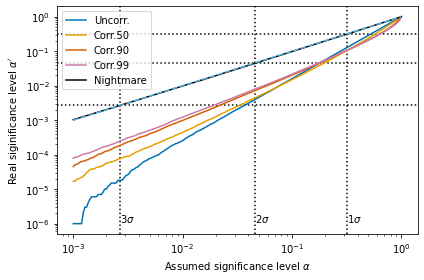

In [21]:
# siginifcance levels
fig, ax = plt.subplots()
for s in [1, 2, 3]:
    SL = chi2.sf(s**2, df=1)
    ax.axhline(SL, color="k", linestyle="dotted")
    ax.axvline(SL, color="k", linestyle="dotted")
    ax.annotate(f"${s}\sigma $ ", (SL, 0.05), xycoords=("data", "axes fraction"))

x = np.logspace(-3, 0, 200)
for name, data in distances.items():
    y = np.sum(data[:, np.newaxis] >= expected.isf(x), axis=0) / len(data)
    ax.plot(x, y, label=name)
ax.plot([1e-3, 1], [1e-3, 1], color="C5", linestyle="dashed")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylabel(r"Real siginificance level $\alpha'$")
ax.set_xlabel(r"Assumed significance level $\alpha$")
ax.legend(loc="upper left")
fig.tight_layout()
fig.savefig(f"plots/{dname}_significance.pdf")

In [9]:
del distances
del data
del p_datasets

In [10]:
C = np.array([
        [1, 0, np.nan, np.nan, 0, 0, 0, 0 ],
        [0, 1, np.nan, np.nan, 0, 0, 0, 0 ],
        [np.nan, np.nan, 1, 0, 0, 0, 0, 0 ],
        [np.nan, np.nan, 0, 1, 0, 0, 0, 0 ],
        [0, 0, 0, 0, 1, 0, np.nan, np.nan ],
        [0, 0, 0, 0, 0, 1, np.nan, np.nan ],
        [0, 0, 0, 0, np.nan, np.nan, 1, 0 ],
        [0, 0, 0, 0, np.nan, np.nan, 0, 1 ],
    ])
derate_covariance(C, accuracy=0.001)

1.3769072990857754

In [11]:
e = 1e-15
C1 = np.array([
        [1, 0, np.nan, np.nan, 0, 0, 0, 0 ],
        [0, 1, np.nan, np.nan, 0, 0, 0, 0 ],
        [np.nan, np.nan, 1, 0, 0, 0, 0, 0 ],
        [np.nan, np.nan, 0, 1, 0, 0, 0, 0 ],
        [0, 0, 0, 0, e, 0, 0, 0 ],
        [0, 0, 0, 0, 0, e, 0, 0 ],
        [0, 0, 0, 0, 0, 0, e, 0 ],
        [0, 0, 0, 0, 0, 0, 0, e ],
    ])
C2 = np.array([
        [e, 0, 0, 0, 0, 0, 0, 0 ],
        [0, e, 0, 0, 0, 0, 0, 0 ],
        [0, 0, e, 0, 0, 0, 0, 0 ],
        [0, 0, 0, e, 0, 0, 0, 0 ],
        [0, 0, 0, 0, 1, 0, np.nan, np.nan ],
        [0, 0, 0, 0, 0, 1, np.nan, np.nan ],
        [0, 0, 0, 0, np.nan, np.nan, 1, 0 ],
        [0, 0, 0, 0, np.nan, np.nan, 0, 1 ],
    ])
derate_covariance([C1, C2], accuracy=0.001, sigma=2, jacobian=np.eye(8)[:5].T)

1.2113800435049293